# Macroprudential Policy and the Housing Market
This notebook solves and simulates the Heterogenous Agent Housing Market (HAH) model and produces the output contained in my Master's thesis. 

**Dependencies:**

The code structure builds upon the framework developed by Jeppe Druedahl & Co. in the [NumEconCopenhagen Project](https://github.com/NumEconCopenhagen)

Packages required for running the notebook are:
- [ConSav](https://pypi.org/project/ConSav/)
- [EconModel](https://pypi.org/project/EconModel/)
- [matplotlib](https://pypi.org/project/matplotlib/)
- [numpy](https://pypi.org/project/numpy/)
- [numba](https://pypi.org/project/numba/)
- [pandas](https://pypi.org/project/pandas/)

### Import packages and ModelClass

In [24]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd

nb.set_num_threads(4) # set equal to the number of cores in your CPU

from HAHModel import HAHModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import data for equivalence scale and life cycle income profile

In [25]:
wd = '/Users/Christian/Dropbox/KU - Polit/KA/Thesis'
data = pd.read_excel(
    io=wd+'/Data/equiscale.xlsx',
    sheet_name='output')

# interpolate income profile and slice
data['chi'] = data['chi'].interpolate(method='linear')
data = data.iloc[3:-3,:]

# extract arrays
n = data['n'].to_numpy(dtype='float')
chi = data['chi'].to_numpy(dtype='float')


## Baseline model

In [27]:
# initialise an instance of baseline model
model_baseline = HAHModelClass(
    name='baseline',
    par={
        'zeta':10,
        #'q':0.8,
        #'omega_dti':8,
        'omega_ltv':0.95,
        'phi':0.8,
        'chi':chi,
        'n':n,
        'do_print':True
        })

model_baseline.precompile_numba() # solve model with very coarse grids --> speed gains
model_baseline.solve(do_assert=True)
model_baseline.simulate()
#model_baseline.save()

 t = 3 solved in 56.9 secs
 t = 2 solved in 57.3 secs
 t = 1 solved in 0.0 secs
 t = 0 solved in 0.0 secs
 total precomputation time  = 74.8 secs
 total stay-time  = 11.1 secs
 total ref-time   = 12.9 secs
 total buy-time   = 10.6 secs
 total rent-time   = 4.8 secs
 full model solved in = 114.2 secs
model simulated in 59.8 secs
numba precompiled in 178.5 secs
 last period bequest computed in 0.0 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 54 solved in 0.2 secs
 v_bar and q computed in 1.9 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 53 solved in 2.0 secs
 v_bar and q computed in 2.3 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 52 solved in 2.4 secs
 v_bar and q computed

In [29]:
# a. unpack
par = model_baseline.par
sim = model_baseline.sim 

# find mean bequest for initial guess
import trans
from EconModel import jit
with jit(model_baseline) as model:
    par = model.par
    ab_tot = 0
    t = par.T-1
    for n in range(par.simN):
        ab_tot += trans.ab_plus_func.py_func(
            sim.a[t,n],
            sim.d_prime[t,n],
            sim.Tda_prime[t,n],
            sim.h_prime[t,n],
            par)
    ab_mean = ab_tot/par.simN
print(f'initial wealth is {np.sum(sim.a0):.4f}')
print(f'total bequest is {ab_tot:.4f}')
print(f'mean bequest is {ab_mean:.4f}')
print(f'average hh pre-tax income is {np.mean(sim.y)*650_000:.4f}')

aggregate housing demand for purchase and rental is 16371384.3300
initial wealth is 165742.3689
total bequest is 177126.8267
mean bequest is 1.7713
average hh pre-tax income is 1278181.8037


In [30]:
import steady_state
steady_state.bequest_loop(model_baseline,ab_mean)

iteration = 1, discrepancy = 0.205729
iteration = 2, discrepancy = 0.036443
iteration = 3, discrepancy = 0.006702
iteration = 4, discrepancy = 0.001115
iteration = 5, discrepancy = 0.000183
iteration = 6, discrepancy = 0.000009
iteration = 7, discrepancy = 0.000001
convergence achieved in 7 simulations, mean bequest = 1.067526


In [31]:
# agggregate housing demand
H_d = np.sum(sim.h) + np.sum(sim.h_tilde)
print(f'aggregate housing demand for purchase and rental is {H_d:.4f}')

aggregate housing demand for purchase and rental is 16837015.9900


### Life Cycle Behaviour for Matching Bequest and Initial Wealth

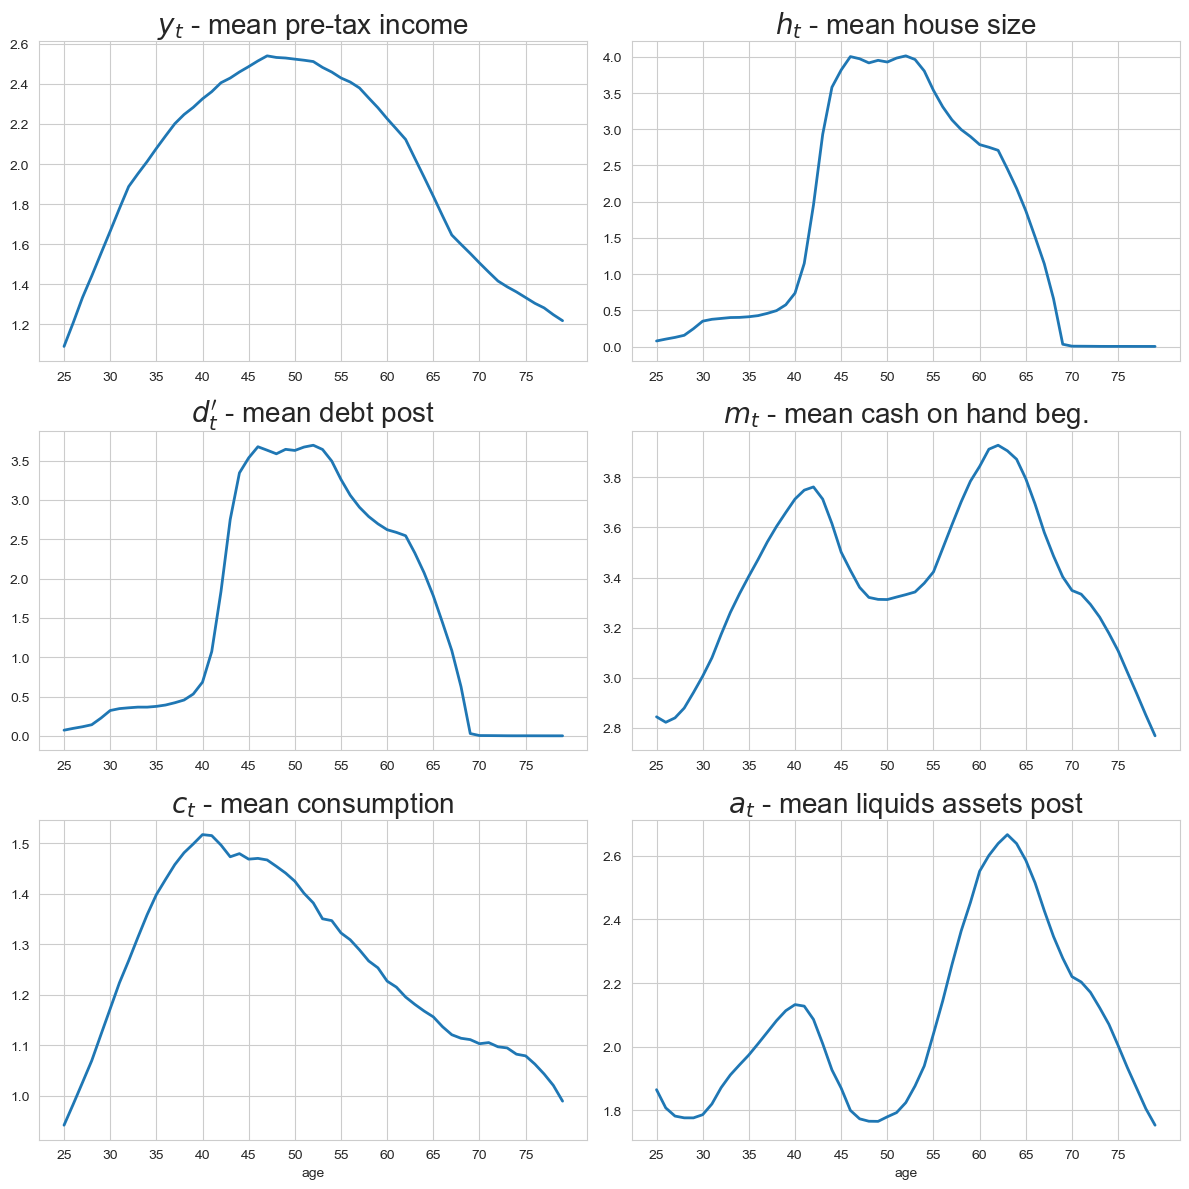

In [32]:
import figs

# average behaviour over the life cycle
figs.lifecycle(model_baseline)

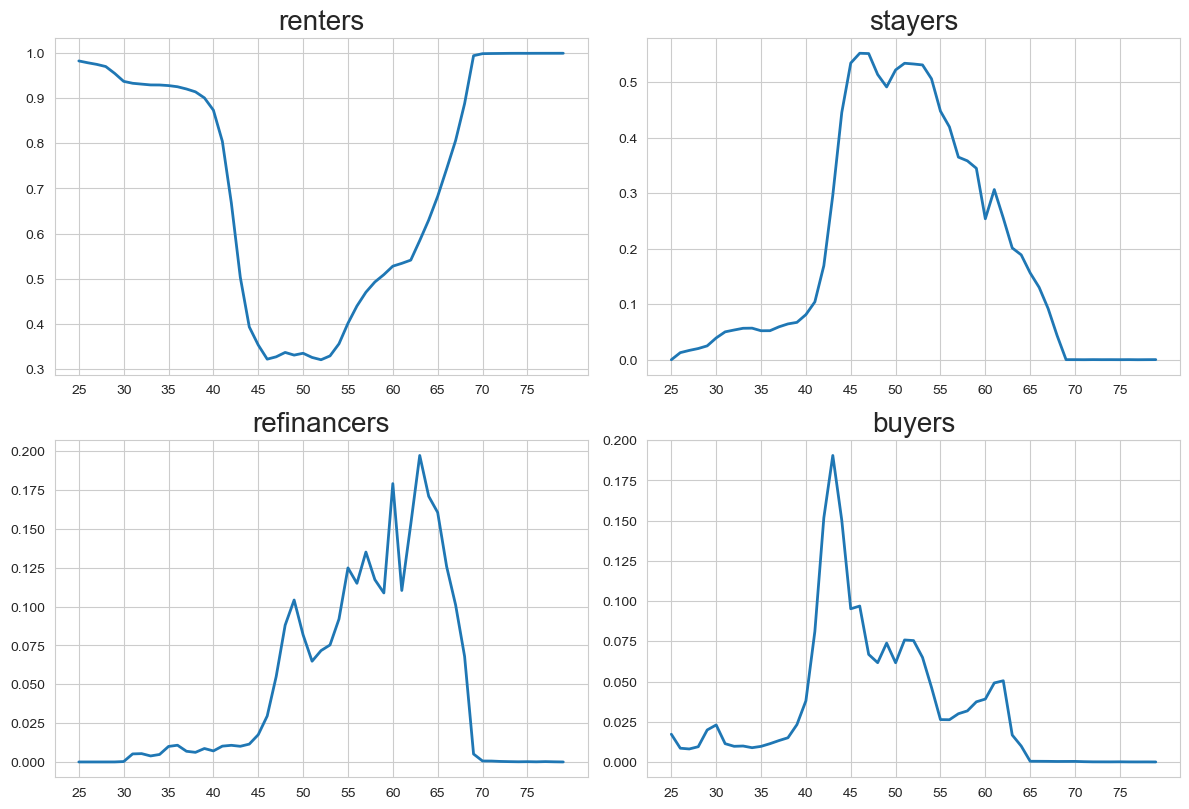

In [33]:
figs.homeownership(model_baseline)

In [34]:

import trans

# a. unpack
par = model_baseline.par
sim = model_baseline.sim 

# b. allocate containers and compute shares
own_share = np.zeros(par.T)
stay_share = np.zeros(par.T)
ref_share = np.zeros(par.T)
buy_share = np.zeros(par.T)
rent_share = np.zeros(par.T)


for t in range(par.T):
    stay_share[t] = np.sum(sim.discrete[t]==0)/par.simN
    ref_share[t] = np.sum(sim.discrete[t]==1)/par.simN
    buy_share[t] = np.sum(sim.discrete[t]==2)/par.simN
    rent_share[t] = np.sum(sim.discrete[t]==3)/par.simN
    own_share[t] = stay_share[t]+ref_share[t]+buy_share[t]

print(f'mean homeownership rate is {np.mean(own_share)}')


mean homeownership rate is 0.2739963636363636


### Test solving the household problem for a few periods

In [13]:
import HHproblems as hhp
from EconModel import jit

par = model_baseline.par

t = par.T-1
Td_len = np.fmin(t+2,par.Td_shape)
Tda_len = np.fmin(par.Tda_bar,par.T-t+1)

with jit(model_baseline) as model: 
    sol = model.sol
    par = model.par
    hhp.last_period_v_bar_q(t,sol,par)
    assert np.all((sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t                  
    print('post decision is done')
    hhp.solve_stay(t,sol,par)
    assert np.all((sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    print('stay is done')
    hhp.solve_ref_fast(t,sol,par)
    assert np.all((sol.c_ref_fast[t] >= 0) & (np.isnan(sol.c_ref_fast[t]) == False)), t
    assert np.all((sol.d_prime_ref_fast[t] >= 0) & (np.isnan(sol.d_prime_ref_fast[t]) == False)), t
    assert np.all((sol.inv_v_ref_fast[t] >= 0) & (np.isnan(sol.inv_v_ref_fast[t]) == False)), t
    print('refinance is done')
    hhp.solve_buy_fast(t,sol,par)
    assert np.all((sol.c_buy_fast[t] >= 0) & (np.isnan(sol.c_buy_fast[t]) == False)), t
    assert np.all((sol.d_prime_buy_fast[t] >= 0) & (np.isnan(sol.d_prime_buy_fast[t]) == False)), t
    assert np.all((sol.inv_v_buy_fast[t] >= 0) & (np.isnan(sol.inv_v_buy_fast[t]) == False)), t                
    print('buy is done')
    hhp.solve_rent(t,sol,par)
    assert np.all((sol.c_rent[t] >= 0) & (np.isnan(sol.c_rent[t]) == False))
    assert np.all((sol.inv_v_rent[t] >= 0) & (np.isnan(sol.inv_v_rent[t]) == False))            
    print('rent is done')
    t = t-1
    print(f'start solving t={t}')
    hhp.postdecision_compute_v_bar_q(t,sol,par)
    assert np.all((sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t                  
    print('post decision is done')
    hhp.solve_stay(t,sol,par)
    assert np.all((sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    print('stay is done')
    hhp.solve_ref_fast(t,sol,par)
    assert np.all((sol.c_ref_fast[t] >= 0) & (np.isnan(sol.c_ref_fast[t]) == False)), t
    assert np.all((sol.d_prime_ref_fast[t] >= 0) & (np.isnan(sol.d_prime_ref_fast[t]) == False)), t
    assert np.all((sol.inv_v_ref_fast[t] >= 0) & (np.isnan(sol.inv_v_ref_fast[t]) == False)), t
    print('refinance fast is done')
    hhp.solve_buy_fast(t,sol,par)
    assert np.all((sol.c_buy_fast[t] >= 0) & (np.isnan(sol.c_buy_fast[t]) == False)), t
    assert np.all((sol.d_prime_buy_fast[t] >= 0) & (np.isnan(sol.d_prime_buy_fast[t]) == False)), t
    assert np.all((sol.inv_v_buy_fast[t] >= 0) & (np.isnan(sol.inv_v_buy_fast[t]) == False)), t                
    print('buy fast is done')
    hhp.solve_rent(t,sol,par)
    assert np.all((sol.c_rent[t] >= 0) & (np.isnan(sol.c_rent[t]) == False))
    assert np.all((sol.inv_v_rent[t] >= 0) & (np.isnan(sol.inv_v_rent[t]) == False))            
    print('rent is done')


post decision is done
stay is done
refinance is done
buy is done
rent is done
start solving t=53
post decision is done
stay is done
refinance fast is done
buy fast is done
rent is done


### Sanity checks